In [20]:
!pip install konlpy
!pip install soynlp
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 네이버 영화 리뷰 데이터 분리

In [60]:
import pandas as pd
import urllib.request
import numpy as np
from tqdm import tqdm
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from tensorflow.keras.models import load_model
from konlpy.tag import Hannanum
import matplotlib.pyplot as plt

In [22]:
# 네이버 영화 리뷰 데이터
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fc23ff63410>)

In [23]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [24]:
test_data

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [25]:
test_data

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [26]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [27]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [28]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

훈련용 리뷰 개수 : 146183
테스트용 리뷰 개수 : 50000


In [29]:
train_data['label'].value_counts()

0    73342
1    72841
Name: label, dtype: int64

In [30]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [31]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [32]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


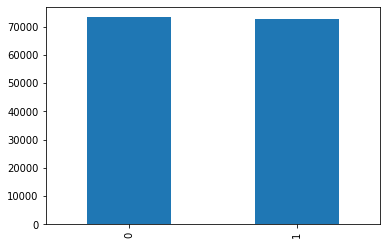

In [33]:
train_data['label'].value_counts().plot(kind = 'bar')

In [34]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [35]:
print(train_data.isnull().values.any())

True


In [36]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [37]:
train_data = train_data.dropna(subset=['document']) # Null 값이 존재하는 행 제거

In [38]:
print(len(train_data))


146182


In [39]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^A-Za-z0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [40]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    113
label         0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [41]:
train_data = train_data.dropna(subset=['document'])
print(len(train_data))

146069


In [42]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^A-Za-z0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(subset=['document']) # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


전처리 후 테스트용 샘플의 개수 : 49119


In [43]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [44]:
okt = Okt()

X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 146069/146069 [06:07<00:00, 397.84it/s]


In [45]:
len(X_train)

146069

In [46]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 49119/49119 [01:56<00:00, 422.16it/s]


In [47]:
X_test

[['굳다', 'ㅋ'],
 ['GDNTOPCLASSINTHECLUB'],
 ['뭐', '야', '평점', '나쁘다', '않다', '10', '점', '짜다', '리', '더', '더욱', '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는'],
 ['3',
  'D',
  '만',
  '아니다',
  '별',
  '다섯',
  '개',
  '주다',
  '왜',
  '3',
  'D',
  '로',
  '나오다',
  '제',
  '심기',
  '불편하다'],
 ['음악', '주가', '되다', '최고', '음악', '영화'],
 ['진정하다', '쓰레기'],
 ['마치',
  '미국',
  '애니',
  '에서',
  '튀어나오다',
  '창의력',
  '없다',
  '로봇',
  '디자인',
  '부터가',
  '고개',
  '젖다'],
 ['갈수록',
  '개판',
  '되다',
  '중국영화',
  '유치하다',
  '내용',
  '없다',
  '폼',
  '잡다',
  '끝나다',
  '말',
  '안되다',
  '무기',
  '유치하다',
  'cg',
  '남무',
  '아',
  '그리다',
  '동사서독',
  '같다',
  '영화',
  '이건',
  '3',
  '류',
  '아',
  '류작',
  '이다'],
 ['이별', '아픔', '뒤', '찾아오다', '새롭다', '인연', '기쁨', 'But', '모든', '사람', '그렇다', '않다'],
 ['괜찮다', '오랜', '만', '포켓몬스터', '잼밌', '어', '요'],
 ['한국', '독립영화', '한계', '그렇게', '아버지', '되다', '비교', '되다'],
 ['청춘',
  '아름답다',
  '그',
  '아름답다',
  '움',
  '이성',
  '을',
  '흔들다',
  '놓다',
  '찰나',
  '아름답다',
  '움',
  '을',
  '자다',
  '포착',
  '섬세하다',
  '아름답다',
  

In [50]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [51]:
print(tokenizer.word_index)


{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '다': 9, '정말': 10, '되다': 11, '재밌다': 12, '적': 13, '만': 14, '같다': 15, '진짜': 16, '로': 17, '점': 18, '아니다': 19, '않다': 20, '에서': 21, '만들다': 22, '나오다': 23, '연기': 24, '것': 25, '평점': 26, '내': 27, '최고': 28, '그': 29, '나': 30, '인': 31, '안': 32, '스토리': 33, '생각': 34, '못': 35, '왜': 36, '드라마': 37, '게': 38, '감동': 39, '사람': 40, '보고': 41, '1': 42, '이렇다': 43, '말': 44, '고': 45, '아깝다': 46, '더': 47, '때': 48, '배우': 49, 'ㅋㅋ': 50, '아': 51, '감독': 52, '거': 53, '그냥': 54, '재미있다': 55, '요': 56, '재미': 57, '내용': 58, '중': 59, '뭐': 60, '까지': 61, '주다': 62, '자다': 63, '하고': 64, '지루하다': 65, '재미없다': 66, '수': 67, '쓰레기': 68, '시간': 69, '네': 70, '가다': 71, '모르다': 72, '들다': 73, '그렇다': 74, '싶다': 75, '지': 76, '작품': 77, '10': 78, '사랑': 79, '알다': 80, '하나': 81, '다시': 82, '마지막': 83, '볼': 84, '이건': 85, '저': 86, '정도': 87, '오다': 88, 'ㅋ': 89, '완전': 90, 'ㅠㅠ': 91, '많다': 92, '처음': 93, 'ㅋㅋㅋ': 94, '장면': 95, '액션': 96, '주인공': 97, '2': 98, '이렇게': 99, '걸': 100, '안되다': 101, '차다': 1

In [52]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 47988
등장 빈도가 2번 이하인 희귀 단어의 수: 27713
단어 집합에서 희귀 단어의 비율: 57.74985413019922
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.070268635295472


In [53]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
# 단어 집합의 크기 : 43001
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 20276


In [54]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [55]:
print(X_train[:3])

[[51, 462, 16, 262, 673], [955, 465, 41, 615, 1, 217, 1481, 24, 981, 687, 20], [391, 2498, 2366, 5658, 2, 225, 9]]


In [56]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [57]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]


In [58]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145690
145690


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.978145377170705


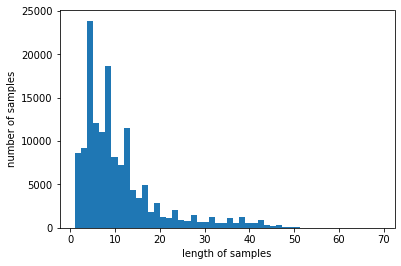

In [61]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [62]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [63]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.13206122589058


In [64]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## LSTM 감성분석

In [65]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1821/1822 [============================>.] - ETA: 0s - loss: 0.3855 - acc: 0.8270
Epoch 1: val_acc improved from -inf to 0.83856, saving model to best_model.h5
1822/1822 [==============================] - 170s 87ms/step - loss: 0.3855 - acc: 0.8270 - val_loss: 0.3666 - val_acc: 0.8386
Epoch 2/15
1821/1822 [============================>.] - ETA: 0s - loss: 0.3210 - acc: 0.8617
Epoch 2: val_acc improved from 0.83856 to 0.85967, saving model to best_model.h5
1822/1822 [==============================] - 155s 85ms/step - loss: 0.3209 - acc: 0.8618 - val_loss: 0.3264 - val_acc: 0.8597
Epoch 3/15
1821/1822 [============================>.] - ETA: 0s - loss: 0.2950 - acc: 0.8756
Epoch 3: val_acc did not improve from 0.85967
1822/1822 [==============================] - 155s 85ms/step - loss: 0.2951 - acc: 0.8756 - val_loss: 0.3286 - val_acc: 0.8584
Epoch 4/15
1821/1822 [============================>.] - ETA: 0s - loss: 0.2754 - acc: 0.8869
Epoch 4: val_acc improved from 0.85967 to 0.8

In [66]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1535/1535 [==============================] - 20s 13ms/step - loss: 0.3250 - acc: 0.8600

 테스트 정확도: 0.8600
